In [2]:
# Standard library imports
import json
import os
import random
import sys
from pprint import pprint

# Third party imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import Bbox, inset_axes
from scipy.special import expit
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import StratifiedShuffleSplit
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_sparse import coalesce
from tqdm import tqdm

# Local application imports
sys.path.append("/pbs/home/e/erodrigu/TesisPhDEzequielRodriguez/Code")
from my_utils.gnn_dataset_utilities import (
    MaskNode,
    PruneGraph2FirstCrown,
    SD433UMDatasetPyG,
    get_station_features,
    plot_graph
)
from my_utils.my_basic_utils import (
    add_zenith_related_columns,
    create_bins,
    filter_dataframe,
    print_banner_text,
)
from my_utils.my_style import MyStyle
from my_utils.torch_models_and_utilities import (
    FocalLoss,
    GNNDiscriminator,
    ROC_resam,
    TraceAnalyzer,
    evaluate_model_to_dataframe,
    get_accuracy,
)

# set PATHS
code_PATH = os.path.abspath(os.path.join(".."))
project_PATH = os.path.abspath(os.path.join(code_PATH, ".."))
data_PATH = os.path.join(project_PATH, "data")

### Version check

In [3]:
print(f"Torch version: {torch.__version__}")
print(f"Torch CUDA version: {torch.version.cuda}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

Torch version: 1.11.0
Torch CUDA version: 10.2
Cuda available: True
Torch geometric version: 2.4.0
Device is: cuda


In [4]:
!nvidia-smi

Wed Sep 25 11:51:25 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla K80    Off  | 00000000:05:00.0 Off |                    0 |
| N/A   48C    P0    71W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset Index Loading

In [6]:
folder_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/"
dir_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/"
index = pd.DataFrame()

# indexes
primaries = ["Proton", "Photon"]
energy_bins = ["16.5_17.0", "17.0_17.5"]
atms = ["01", "03", "08", "09"]
indexes = [
    f"index_hadron_rec_{x}_{y}_{z}.csv"
    for x in primaries
    for y in energy_bins
    for z in atms
]

# create the index by appending
for index_name in indexes:
    proton_index = pd.read_csv(folder_path + index_name, on_bad_lines="skip")
    photon_rec_index = pd.read_csv(
        folder_path + index_name.replace("hadron", "photon"), on_bad_lines="skip"
    )
    index_ = pd.merge(
        proton_index,
        photon_rec_index,
        on=["filename", "atm_model", "shower_id", "use_id"],
        how="left",
    )
    index = pd.concat([index, index_], ignore_index=True)

index = index.drop_duplicates()
index = index.drop_duplicates(subset=["filename"])
# we won't train using iron
index["mass_group"] = index["filename"].str.split(pat="_", expand=True)[0]
index = index[index["mass_group"] != "Iron"]
print(f"Events before quality cuts: {len(index)}")

Events before quality cuts: 398227


In [7]:
index.describe()

/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,atm_model,shower_id,use_id,energyMC,zenithMC,showerSize,showerSizeError,isT5,is6T5,Xmax,hottestid,nearestid,nCandidates,bLDF,isSaturated,photon_energy,s_250,equivalent_energy,M1
count,398227.000000,398227.000000,398227.000000,3.982270e+05,398227.000000,398227.000000,398227.000000,398227.000000,398227.000000,398227.000000,398227.000000,398227.0,398227.000000,398227.000000,398227.000000,3.981870e+05,398187.000000,3.979650e+05,3.979650e+05
mean,5.250465,624.671403,10.489314,1.238382e+17,0.677721,16.222010,1.188039,0.671835,0.671835,731.265860,3348.198573,0.0,7.788909,0.761453,0.116549,1.642059e+17,29.006530,1.202942e+17,-inf
std,3.345009,360.883823,5.766413,7.912391e+16,0.273104,17.278987,0.866914,0.469546,0.469546,97.612257,1963.274853,0.0,5.378215,0.426196,0.320883,8.526831e+18,32.499657,6.294315e+17,NaN
min,1.000000,0.000000,1.000000,3.162770e+16,0.005836,0.000000,0.000000,0.000000,0.000000,541.340000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-inf
25%,1.000000,312.000000,5.000000,5.628890e+16,0.470053,3.482985,0.674117,0.000000,0.000000,674.485000,4011.000000,0.0,4.000000,1.000000,0.000000,0.000000e+00,5.067435,3.012160e+16,NaN
50%,8.000000,625.000000,10.000000,9.965710e+16,0.698197,10.672800,1.193160,1.000000,1.000000,726.160000,4030.000000,0.0,8.000000,1.000000,0.000000,7.304100e+16,17.938700,8.349710e+16,9.208530e-02
75%,9.000000,937.000000,15.000000,1.788410e+17,0.903215,23.710200,1.749920,1.000000,1.000000,776.310000,4099.000000,0.0,12.000000,1.000000,0.000000,1.755365e+17,42.080150,1.730690e+17,9.090410e-01
max,9.000000,1249.000000,20.000000,3.161470e+17,1.134360,486.789000,25.041500,1.000000,1.000000,7344.800000,5813.000000,0.0,23.000000,1.000000,1.000000,5.210900e+21,245.140000,2.359760e+20,2.089770e+00


### Quality Cuts and Binning

In [9]:
index = index.sample(frac=1)
index.loc[index["filename"].str.contains("Photon"), "isPhoton"] = 1
index.loc[index["filename"].str.contains("Proton"), "isPhoton"] = 0

index["sin2zenith"] = np.sin(index["zenithMC"]) ** 2
# photon efficiency from fit from simulations
index["est_efficiency"] = (
    15.4074
    + 17.4996 * (np.log10(index["energyMC"]) - 17)
    - 12.7485 * index["sin2zenith"]
    - 20.7650 * index["sin2zenith"] ** 2
    - 13.1239 * (np.log10(index["energyMC"]) - 17) * index["sin2zenith"]
)
index["est_efficiency"] = expit(index["est_efficiency"])

feature_filters = {
    "zenithMC": {"filter_type": "range", "max_cut": np.deg2rad(45)},
    "photon_energy": {"filter_type": "range", "min_cut": 1},
#    "est_efficiency": {"filter_type": "range", "min_cut": 0.9},
    "isT5": {"filter_type": "value", "value_to_keep": 1}
    #"is5T5": {"filter_type": "value", "value_to_keep": 1},
    #"is6T5": {"filter_type": "value", "value_to_keep": 1},

}
index = filter_dataframe(index, feature_filters)

index, e_bin_centers, e_bin_edges, e_labels = create_bins(
    index,
    lower_val=10**16.5,
    upper_val=10**17.5,
    num=6,
    unbinned_col="energyMC",
    bin_column_name="e_bin",
    bin_width="equal_logarithmic",
)

index, z_bin_centers, z_bin_edges, z_labels = create_bins(
    index,
    lower_val=0,
    upper_val=np.sin(np.deg2rad(45)) ** 2,
    num=4,
    unbinned_col="sin2zenith",
    bin_column_name="z_bin",
    bin_width="equal",
)

index = index.loc[~index["e_bin"].isnull()]

# problems in ADSTs
exclude_list = [
"Photon_17.0_17.5_011102_11",
"Photon_17.0_17.5_080595_20"
]
index = index[~index['filename'].isin(exclude_list)]

print(f"Events after quality cuts: {len(index)}")

Events after quality cuts: 209158


### Balanced Dataset Division

In [34]:
# def get_fatt_ph(sec, dsec):
#     def func(x, p0, p1, p2, p3):
#         return p0 * (1 + (x - p2) / p1)**(p1 / p3) * np.exp(-(x - p2) / p3)

#     # Parameters and their errors
#     popt = [3.88940e+01, 6.23117e-01, 1.00999e+00, 9.04938e-02]
#     perr = [5.62431e-02, 5.26757e-02, 2.32738e-03, 4.79750e-03]

#     # Evaluate the function
#     f = func(sec, *popt)

#     # Unpack parameters and their errors
#     f0, f1, f2, f3 = popt
#     df0, df1, df2, df3 = perr

#     # Calculate the error
#     factor = 1 + (sec - f2) / f1
#     var0 = (f * df0 / f0)**2
#     var1 = (f * (np.log(factor) / f3 - (sec - f2) / (f1 * f3 * factor)) * df1)**2
#     var2 = (f * (f2 - sec) * df2 / (f3 * (f2 - sec - f1)))**2
#     var3 = (f * (f1 * np.log(factor) - sec + f2) * df3 / f3**2)**2
#     var4 = (-f * (sec - f2) * dsec / (f3 * (sec - f2 + f1)))**2
#     df = np.sqrt(var0 + var1 + var2 + var3 + var4)

#     return [f, df]

# def get_norm_fatt_ph(sec, dsec):
#     v_fatt_ph = get_fatt_ph(sec, dsec)
#     secref = np.cos(30 * np.pi / 180)**-1
#     norm = get_fatt_ph(secref, 0)[0]
#     v = [v_fatt_ph[0] / norm, v_fatt_ph[1] / norm]
#     return v

# def get_fatt_pr(x, dx):
#     def func(x, a, b, c):
#         return 1 + a * x + b * x**2 + c * x**3

#     # Parameters and their errors
#     popt = [1.88357, -1.74331, -3.45984]
#     perr = [2.81332e-03, 1.45271e-02, 5.38753e-02]

#     # Evaluate the function
#     f = func(x, *popt)

#     # Unpack parameters and their errors
#     f1, f2, f3 = popt
#     df1, df2, df3 = perr

#     # Calculate the error
#     var1 = (x * df1)**2
#     var2 = (x**2 * df2)**2
#     var3 = (x**3 * df3)**2
#     varx = ((f1 + 2 * f2 * x + 3 * f3 * x**2) * dx)**2
#     df = np.sqrt(var1 + var2 + var3 + varx)

#     return [f, df]

# def get_photon_norm():
#     secref = np.cos(30 * np.pi / 180)**-1
#     photon_norm = get_fatt_ph(secref, 0)[0]
#     return photon_norm

# photon_norm = get_photon_norm()

# x = np.cos(np.deg2rad(30))**2 - np.cos(np.deg2rad(30))**2
# dx = 1
# alpha = 1.15 * (1 - 0.192 * pow(pow(np.cos(np.deg2rad(30)), 2), 2.96))
# eq_energy = pow(10,16) * pow((38.9545 / (get_fatt_pr(x, dx)[0]*photon_norm)), (1/alpha))

In [10]:
# Combine the two categorical variables for stratified sampling
index["categorical_balance"] = (
    index["isPhoton"].astype(str)
    + "_"
    + index["e_bin"].astype(str)
    + "_"
    + index["z_bin"].astype(str)
)

random_seed = 42
stratified_split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.25, random_state=random_seed
)

for dev_index_, test_index_ in stratified_split.split(
    index, index["categorical_balance"]
):
    # Original Training set
    dev_index = index.iloc[dev_index_]

    # Testing set
    test_index = index.iloc[test_index_]

# Further split the original training set into train and validation sets
validation_size = 0.25  # Adjust as needed
split = StratifiedShuffleSplit(
    n_splits=1, test_size=validation_size, random_state=random_seed
)

for train_index_, validation_index_ in split.split(
    dev_index, dev_index["categorical_balance"]
):
    train_index = dev_index.iloc[train_index_]
    validation_index = dev_index.iloc[validation_index_]

# Print the size of each dataset
print("Train dataset size:", train_index.shape[0])
print("Validation dataset size:", validation_index.shape[0])
print("Test dataset size:", test_index.shape[0])

Train dataset size: 117651
Validation dataset size: 39217
Test dataset size: 52290


### Generation of Normalization Dictionary

In [8]:
dir_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/"
root_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/root/"

test_run = True
n_train_evts = 1000 if test_run else len(train_index)
n_val_evts = 0 if test_run else len(validation_index)
n_test_evts = 0 if test_run else len(test_index)

# set paths according to index
train_paths = list(train_index.iloc[:n_train_evts, 0].values)
train_paths = list(map(lambda item: dir_path + item + ".json", train_paths))
val_paths = list(validation_index.iloc[:n_val_evts, 0].values)
val_paths = list(map(lambda item: dir_path + item + ".json", val_paths))
test_paths = list(test_index.iloc[:n_test_evts, 0].values)
test_paths = list(map(lambda item: dir_path + item + ".json", test_paths))

In [9]:
dict_already_computed = True
if dict_already_computed:
    normalization_dict = {
 'WCD_signal': {'mean': 0.9242377699753578,
                'method': 'standardization',
                'std': 0.7037094813650729},
 'deltaTimeHottest': {'mean': -47.27531568592806,
                      'method': 'standardization',
                      'std': 603.6062483849028},
 'effective_area': {'max': 31.380000000000003,
                    'method': 'min_max_scaling',
                    'min': 0},
 'pmt_number': {'max': 3, 'method': 'min_max_scaling', 'min': 1},
 'rho_mu': {'mean': 0.21510971141596952,
            'method': 'standardization',
            'std': 0.9057438827119321},
 'x': {'mean': -1.01887806305201,
       'method': 'standardization',
       'std': 364.5171135403138},
 'y': {'mean': -0.06542848666299515,
       'method': 'standardization',
       'std': 356.8056580363697},
 'z': {'mean': -0.16543275617686548,
       'method': 'standardization',
       'std': 6.410170534866934}}

else:
    # takes around 40 min
    station_features = [
        "x",
        "y",
        "z",
        "deltaTimeHottest",
        "pmt_number",
        #"WCD_signal",
        "effective_area",
        "rho_mu",  # muon density will always go latest
    ]

    massive_array = get_station_features(train_paths, station_features)
    mean_array = np.nanmean(massive_array, axis=0)
    std_array = np.nanstd(massive_array, axis=0)

    normalization_dict = {}
    for idx, feature in enumerate(station_features):
        normalization_dict[feature] = {}
        normalization_dict[feature]["method"] = "standardization"
        normalization_dict[feature]["mean"] = mean_array[idx]
        normalization_dict[feature]["std"] = std_array[idx]

    # overwrite some values that are better normalized as follows
    normalization_dict["pmt_number"] = {
        "method": "min_max_scaling",
        "min": 1,
        "max": 3,
    }
    normalization_dict["effective_area"] = {
        
        "method": "min_max_scaling",
        "min": 0,
        "max": 3 * 10.46,
    }  # Kathy Turner will have more than 3 modules in data

pprint(normalization_dict)

{'WCD_signal': {'mean': 0.9242377699753578,
                'method': 'standardization',
                'std': 0.7037094813650729},
 'deltaTimeHottest': {'mean': -47.27531568592806,
                      'method': 'standardization',
                      'std': 603.6062483849028},
 'effective_area': {'max': 31.380000000000003,
                    'method': 'min_max_scaling',
                    'min': 0},
 'pmt_number': {'max': 3, 'method': 'min_max_scaling', 'min': 1},
 'rho_mu': {'mean': 0.21510971141596952,
            'method': 'standardization',
            'std': 0.9057438827119321},
 'x': {'mean': -1.01887806305201,
       'method': 'standardization',
       'std': 364.5171135403138},
 'y': {'mean': -0.06542848666299515,
       'method': 'standardization',
       'std': 356.8056580363697},
 'z': {'mean': -0.16543275617686548,
       'method': 'standardization',
       'std': 6.410170534866934}}


In [ ]:
plot_train_distributions = False

In [10]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,0], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$(x_{\text{hottest}} - x) / \text{m}$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

NameError: name 'massive_array' is not defined

In [ ]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,1], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$(y_{\text{hottest}} - y) / \text{m}$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

In [ ]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,2], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$(z_{\text{hottest}} - z) / \text{m}$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

In [ ]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,3], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$(t_{\text{hottest}} - t) / \text{m}$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

In [ ]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,4], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$N_{\text{PMTs}}$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

In [ ]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,5], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$\lg(S/\text{VEM})$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

In [ ]:
if plot_train_distributions:    
    
    histogram, bin_edges = np.histogram(massive_array[:,6], bins=100, density=True)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$\text{Active Area}/m^2$"
    #ax.set_ylim(-200, 350)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

In [ ]:
if plot_train_distributions:

    histogram, bin_edges = np.histogram(massive_array[:,7], bins=10000, density=False)

    myStyle = MyStyle('1fig', markers=None)
    fig, ax = plt.subplots()

    # plot the histogram
    ax.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="red", alpha=0.4, color="r")
    ax.set_ylabel("norm. counts")

    #feature lim and labels
    feature_label = r"$\rho_{\mu}/\text{m}^-2$"
    ax.set_xlim(-0.2, 0)
    ax.set_xlabel(feature_label)

    plt.tight_layout()
    plt.show()

### Datasets and Loaders

In [108]:
dir_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/"
root_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/root/"

# set paths according to index
train_paths = list(train_index.iloc[:1000, 0].values)
train_paths = list(map(lambda item: dir_path + item + ".json", train_paths))

train_PyG_ds = SD433UMDatasetPyG(
    file_paths=train_paths,
    norm_dict=normalization_dict,
    root=root_path,
    sample_PMTs=True,
    sample_MD_mods=True,
    n_time_bins=60,
    neighbourhood_cut=450,
    
)

In [12]:
def plot_graph(
    graph,
    feature_name,
    norm_dict,
    ax,
    plot_edges=True,
    node_color="cornflowerblue",
    size_amplifier=1,
    x_pos_offset=0,
    node_size_label=None,
    plot_core = False,
    linestyle="solid",
):

    def retrieve_original_value(feature, method_info):
        method = method_info["method"]
        if method == "standardization":
            return feature * method_info["std"] + method_info["mean"]
        elif method == "min_max_scaling":
            return (
                feature * (method_info["max"] - method_info["min"]) + method_info["min"]
            )
        else:
            raise ValueError(f"Unsupported method: {method}")

    # Plot edges
    if plot_edges:
        for src, dst in graph["edge_index"].t().tolist():
            ax.plot(
                [
                    graph["pos"][src, 0] + x_pos_offset,
                    graph["pos"][dst, 0] + x_pos_offset,
                ],
                [graph["pos"][src, 1], graph["pos"][dst, 1]],
                color="gray",
                linestyle=linestyle,
                alpha=0.33,
            )

    # Filter nodes based on the specified feature
    feature_index = torch.tensor(
        [i for i, feat in enumerate(graph["station_features"]) if feat == feature_name]
    )
    node_sizes = graph["x"][:, feature_index]
    # Adjust node sizes based on method
    node_sizes = retrieve_original_value(node_sizes, norm_dict[feature_name])
    # Plot nodes above edges
    ax.scatter(
        graph["pos"][:, 0] + x_pos_offset,
        graph["pos"][:, 1],
        s=size_amplifier * node_sizes,
        color=node_color,
        label=node_size_label,
        zorder=2,
    )
    
    if plot_core:
        ax.scatter(
        graph["core"][0],
        graph["core"][1], marker='x', color="green", label="MC core")
        
    delays = retrieve_original_value(graph.x[:,3], norm_dict["deltaTimeHottest"])
    # Add insets for node traces and other stuff
    for i, (x, y) in enumerate(graph["pos"]):
        ax.text(
            x.item() - 70,
            y.item() - 60,
            graph.station_list[i],
            transform=ax.transData,
            fontsize=14,
        )
        ax.text(
            x.item() - 70,
            y.item() - 120,
            f"$\Delta t_{{ \text{{hottest}} }}=$ {round(delays[i].item(), 0)} ns",
            transform=ax.transData,
            fontsize=14,
        )
        inset_ax = ax.inset_axes(
            [x.item() - 100, y.item() + 25, 200, 100], transform=ax.transData
        )
        inset_ax.plot(graph.x_traces[i, :], color="black")
        inset_ax.axis("off")

In [45]:
def plot_graph(
    graph,
    feature_name,
    norm_dict,
    ax,
    plot_edges=True,
    node_color="cornflowerblue",
    size_amplifier=1,
    x_pos_offset=0,
    node_size_label=None,
    plot_core=False,
    edge_color="grey",
    linestyle="solid",
):

    def retrieve_original_value(feature, method_info):
        method = method_info["method"]
        if method == "standardization":
            return feature * method_info["std"] + method_info["mean"]
        elif method == "min_max_scaling":
            return (
                feature * (method_info["max"] - method_info["min"]) + method_info["min"]
            )
        else:
            raise ValueError(f"Unsupported method: {method}")

    # Plot edges
    if plot_edges:
        for src, dst in graph["edge_index"].t().tolist():
            ax.plot(
                [
                    graph["pos"][src, 0] + x_pos_offset,
                    graph["pos"][dst, 0] + x_pos_offset,
                ],
                [graph["pos"][src, 1], graph["pos"][dst, 1]],
                color=edge_color,
                linestyle=linestyle,
                alpha=0.33,
            )

    # Filter nodes based on the specified feature
    feature_index = torch.tensor(
        [i for i, feat in enumerate(graph["station_features"]) if feat == feature_name]
    )
    node_sizes = graph["x"][:, feature_index]
    # Adjust node sizes based on method
    node_sizes = retrieve_original_value(node_sizes, norm_dict[feature_name])
    # Plot nodes above edges
    ax.scatter(
        graph["pos"][:, 0] + x_pos_offset,
        graph["pos"][:, 1],
        s=size_amplifier * node_sizes,
        color=node_color,
        label=node_size_label,
        zorder=2,
    )
    
    if plot_core:
        ax.scatter(
        graph["core"][0],
        graph["core"][1], marker='x', color="green", label="MC core")
        
    delays = retrieve_original_value(graph.x[:,3], norm_dict["deltaTimeHottest"])
    # Add insets for node traces and other stuff
    for i, (x, y) in enumerate(graph["pos"]):
        ax.text(
            x.item() - 70,
            y.item() - 60,
            graph.station_list[i],
            transform=ax.transData,
            fontsize=14,
        )
        ax.text(
            x.item() - 110,
            y.item() - 120,
            f"$\Delta t_{{ \\text{{hottest}} }}=$ {round(delays[i].item(), 0)} ns",
            transform=ax.transData,
            fontsize=14,
        )
        inset_ax = ax.inset_axes(
            [x.item() - 100, y.item() + 25, 200, 100], transform=ax.transData
        )
        inset_ax.plot(graph.x_traces[i, :], color="black")
        inset_ax.axis("off")
        
def plot_simple_graph(graph, ax, kw_args_nodes, kw_args_edges, kw_args_traces, plot_edges=True, plot_traces=True, ):
    
    # plotting edges
    if plot_edges:
        
        for src, dst in graph["edge_index"].t().tolist():
            ax.plot(
                [
                    graph["pos"][src, 0],
                    graph["pos"][dst, 0],
                ],
                [graph["pos"][src, 1], graph["pos"][dst, 1]],
                **kw_args_edges
            )
            
    # plotting nodes
    for i, (x, y) in enumerate(graph["pos"]):
        
        plt.scatter(x, y, **kw_args_nodes)
        
        if plot_traces:
            inset_ax = ax.inset_axes(
            [x.item() - 100, y.item() + 25, 200, 100], transform=ax.transData
            )
            inset_ax.plot(graph.x_traces[i, :], color="black", **kw_args_traces)
            inset_ax.axis("off")

In [172]:
train_PyG_ds = SD433UMDatasetPyG(
    file_paths=train_paths,
    norm_dict=normalization_dict,
    root=root_path,
    sample_PMTs=True,
    sample_MD_mods=True,
    n_time_bins=60,
    neighbourhood_cut=450,
    
)

graph = train_PyG_ds[10]

In [173]:
graph

Data(x=[11, 7], edge_index=[2, 66], pos=[11, 2], id='Proton_17.0_17.5_030633_13', y=0, x_traces=[11, 60], effective_area=[11, 3], md_Nmu=[11, 3], station_list=[11], station_features=[7], core=[2], distance2hottest_list=[11])

In [174]:
graph.x

tensor([[ 2.7951e-03,  1.8337e-04,  2.5808e-02,  7.8321e-02,  1.0000e+00,
          3.9061e-01,  1.4867e+00],
        [ 1.0235e+00,  5.9507e-01, -1.3304e+00, -3.6899e-01,  1.0000e+00,
          7.8122e-01,  1.1472e-01],
        [-1.0143e+00, -6.1285e-01, -1.0189e+00,  4.1795e-01,  1.0000e+00,
          1.1718e+00,  2.1057e-01],
        [ 1.0335e+00, -6.0197e-01, -1.7316e+00,  9.9780e-01,  5.0000e-01,
          7.8122e-01,  7.3123e-02],
        [ 2.4134e-02,  1.2174e+00, -1.0339e+00, -1.1559e+00,  1.0000e+00,
          1.1718e+00, -2.8772e-02],
        [ 5.8141e-03, -1.2266e+00, -1.2147e+00,  1.3291e+00,  1.0000e+00,
          7.8122e-01,  8.9971e-01],
        [-1.0266e+00,  6.4181e-01, -1.7085e+00, -8.7429e-01,  1.0000e+00,
          7.8122e-01,  2.7563e-02],
        [ 1.0387e+00, -1.7990e+00, -3.6971e-01,  2.0332e+00,  1.0000e+00,
          1.1718e+00, -3.2342e-02],
        [-1.0148e+00,  1.8243e+00, -1.3339e-01, -2.1582e+00,  0.0000e+00,
          1.1718e+00, -1.2084e-01],
        [-

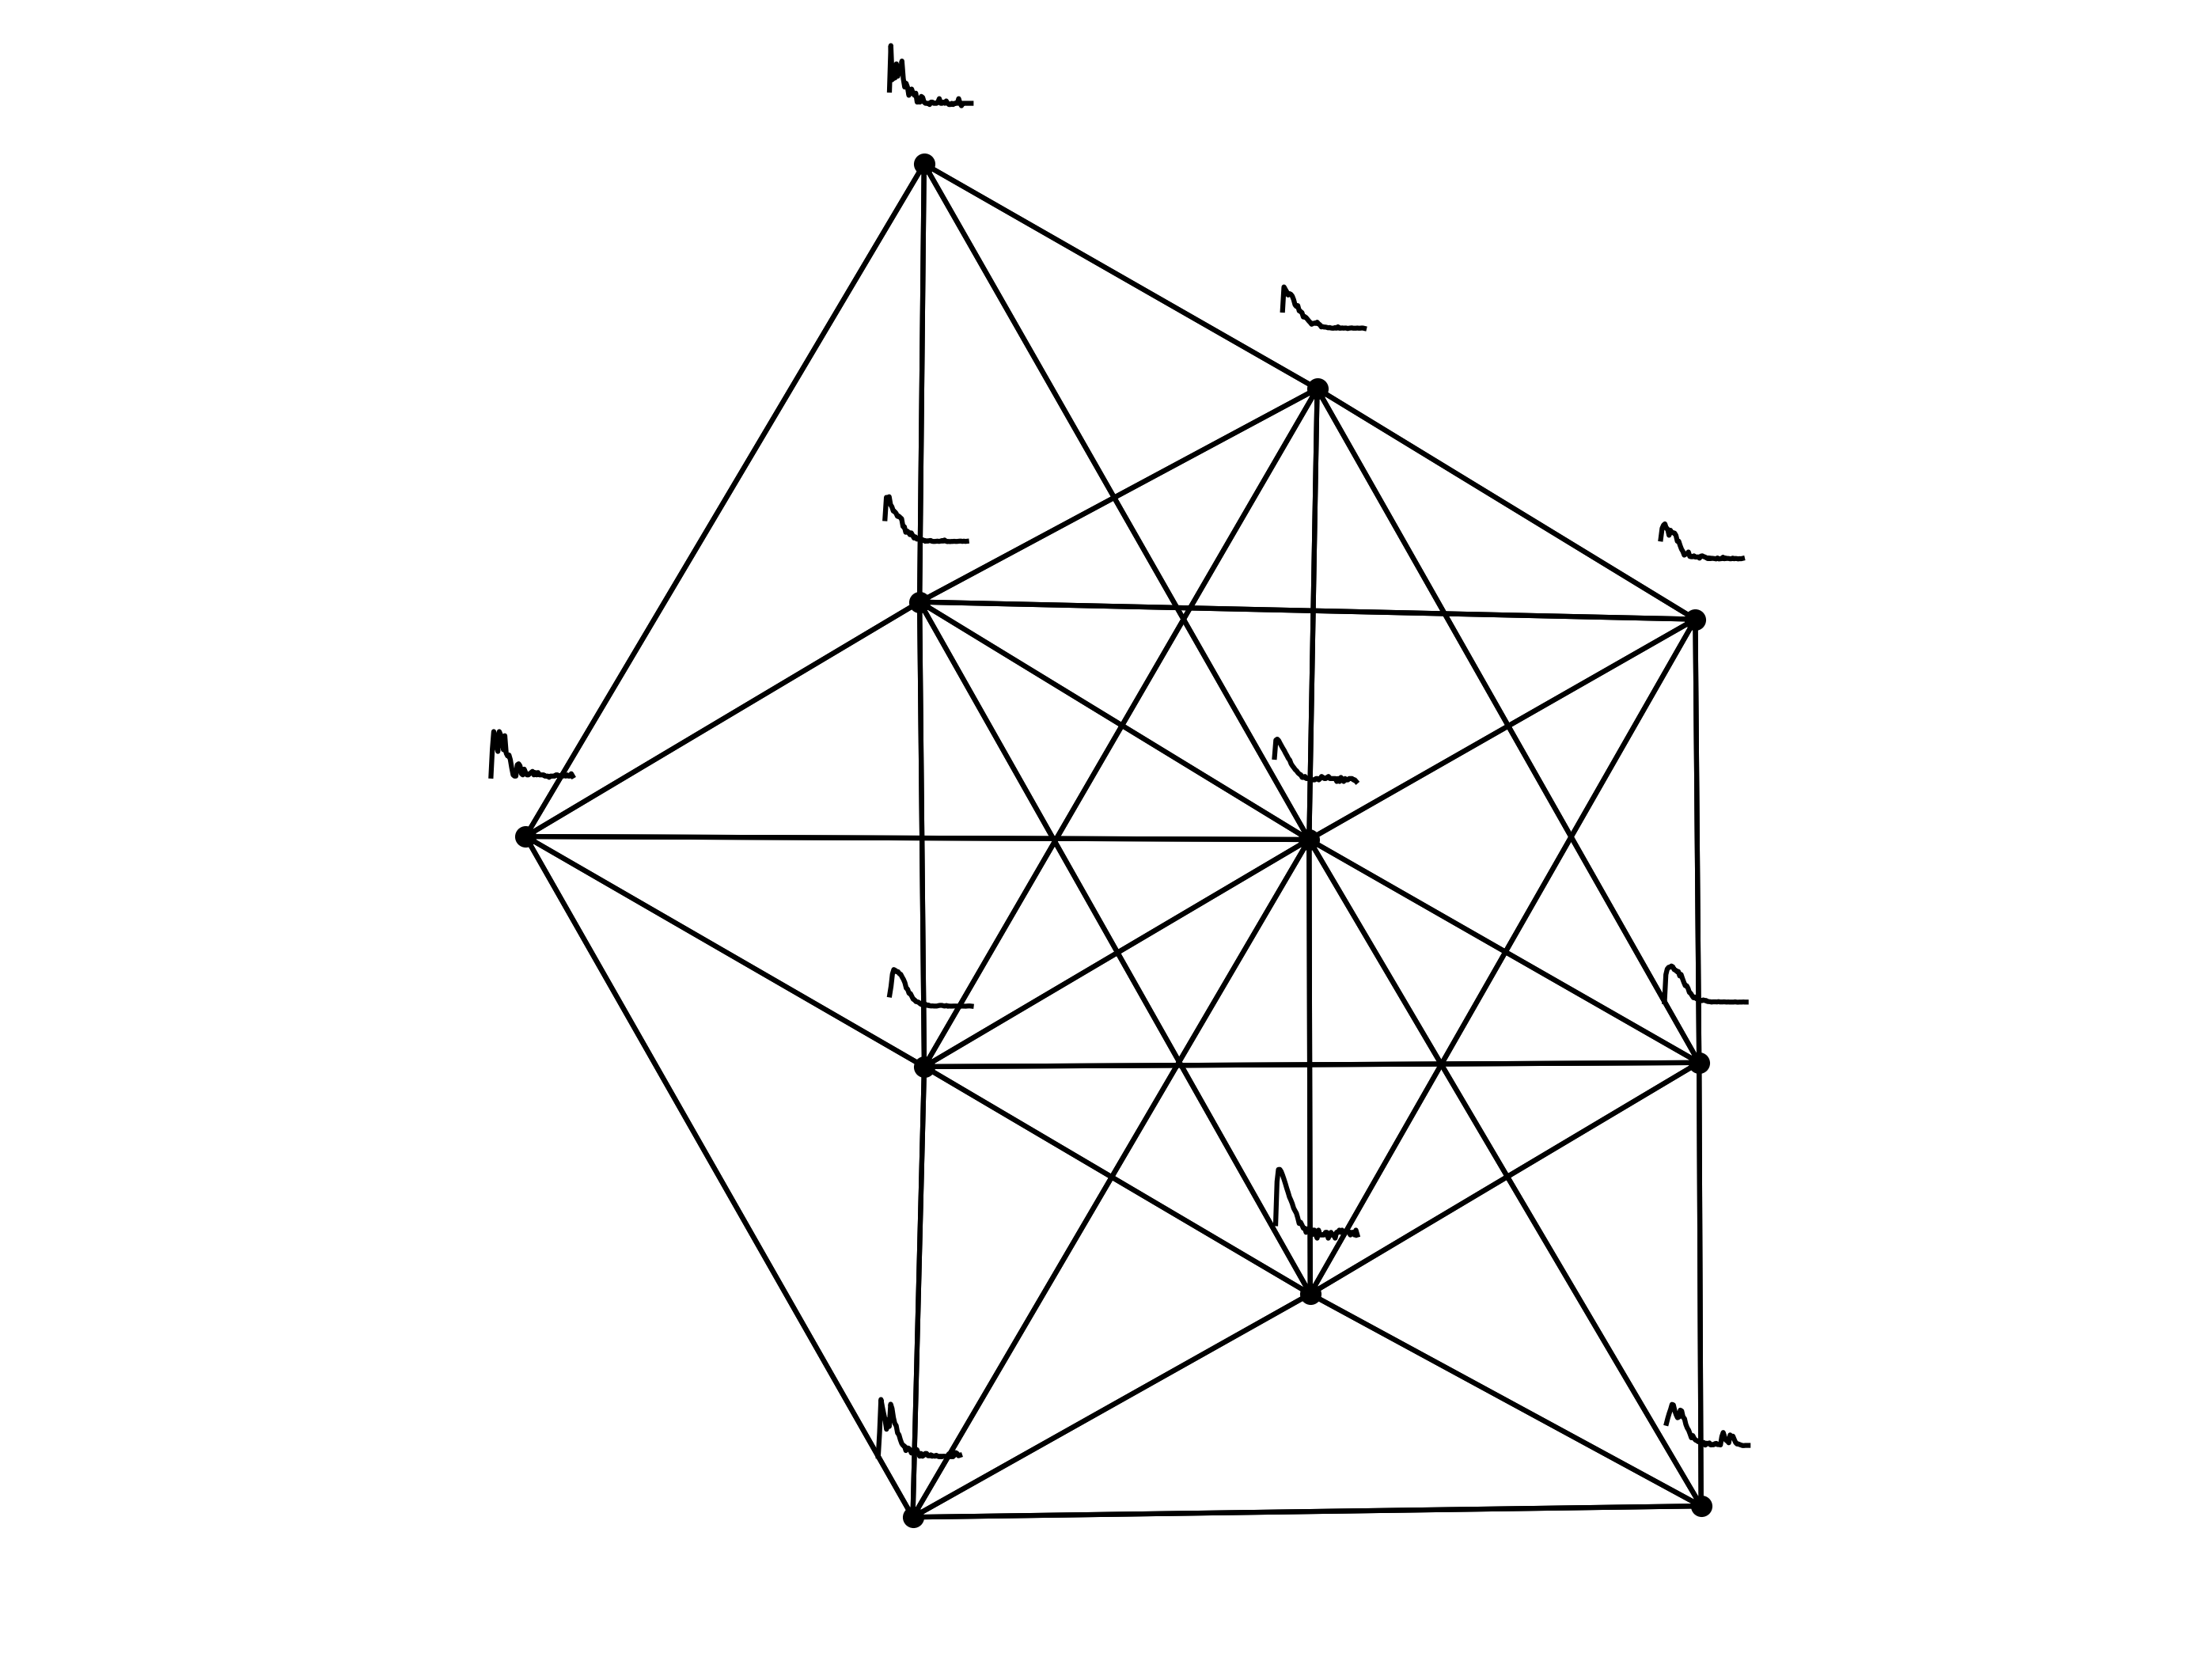

In [175]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()

color="black"
kw_args_nodes = {"color":color}
kw_args_edges = {"color":color}
kw_args_traces = {}

plot_simple_graph(graph, ax=ax, kw_args_nodes=kw_args_nodes, kw_args_edges=kw_args_edges, kw_args_traces=kw_args_traces)
ax.axis("off")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [180]:
node_masking_transform =  MaskNode(max_nodes2prune=2)
masked_graph1 = node_masking_transform(graph)

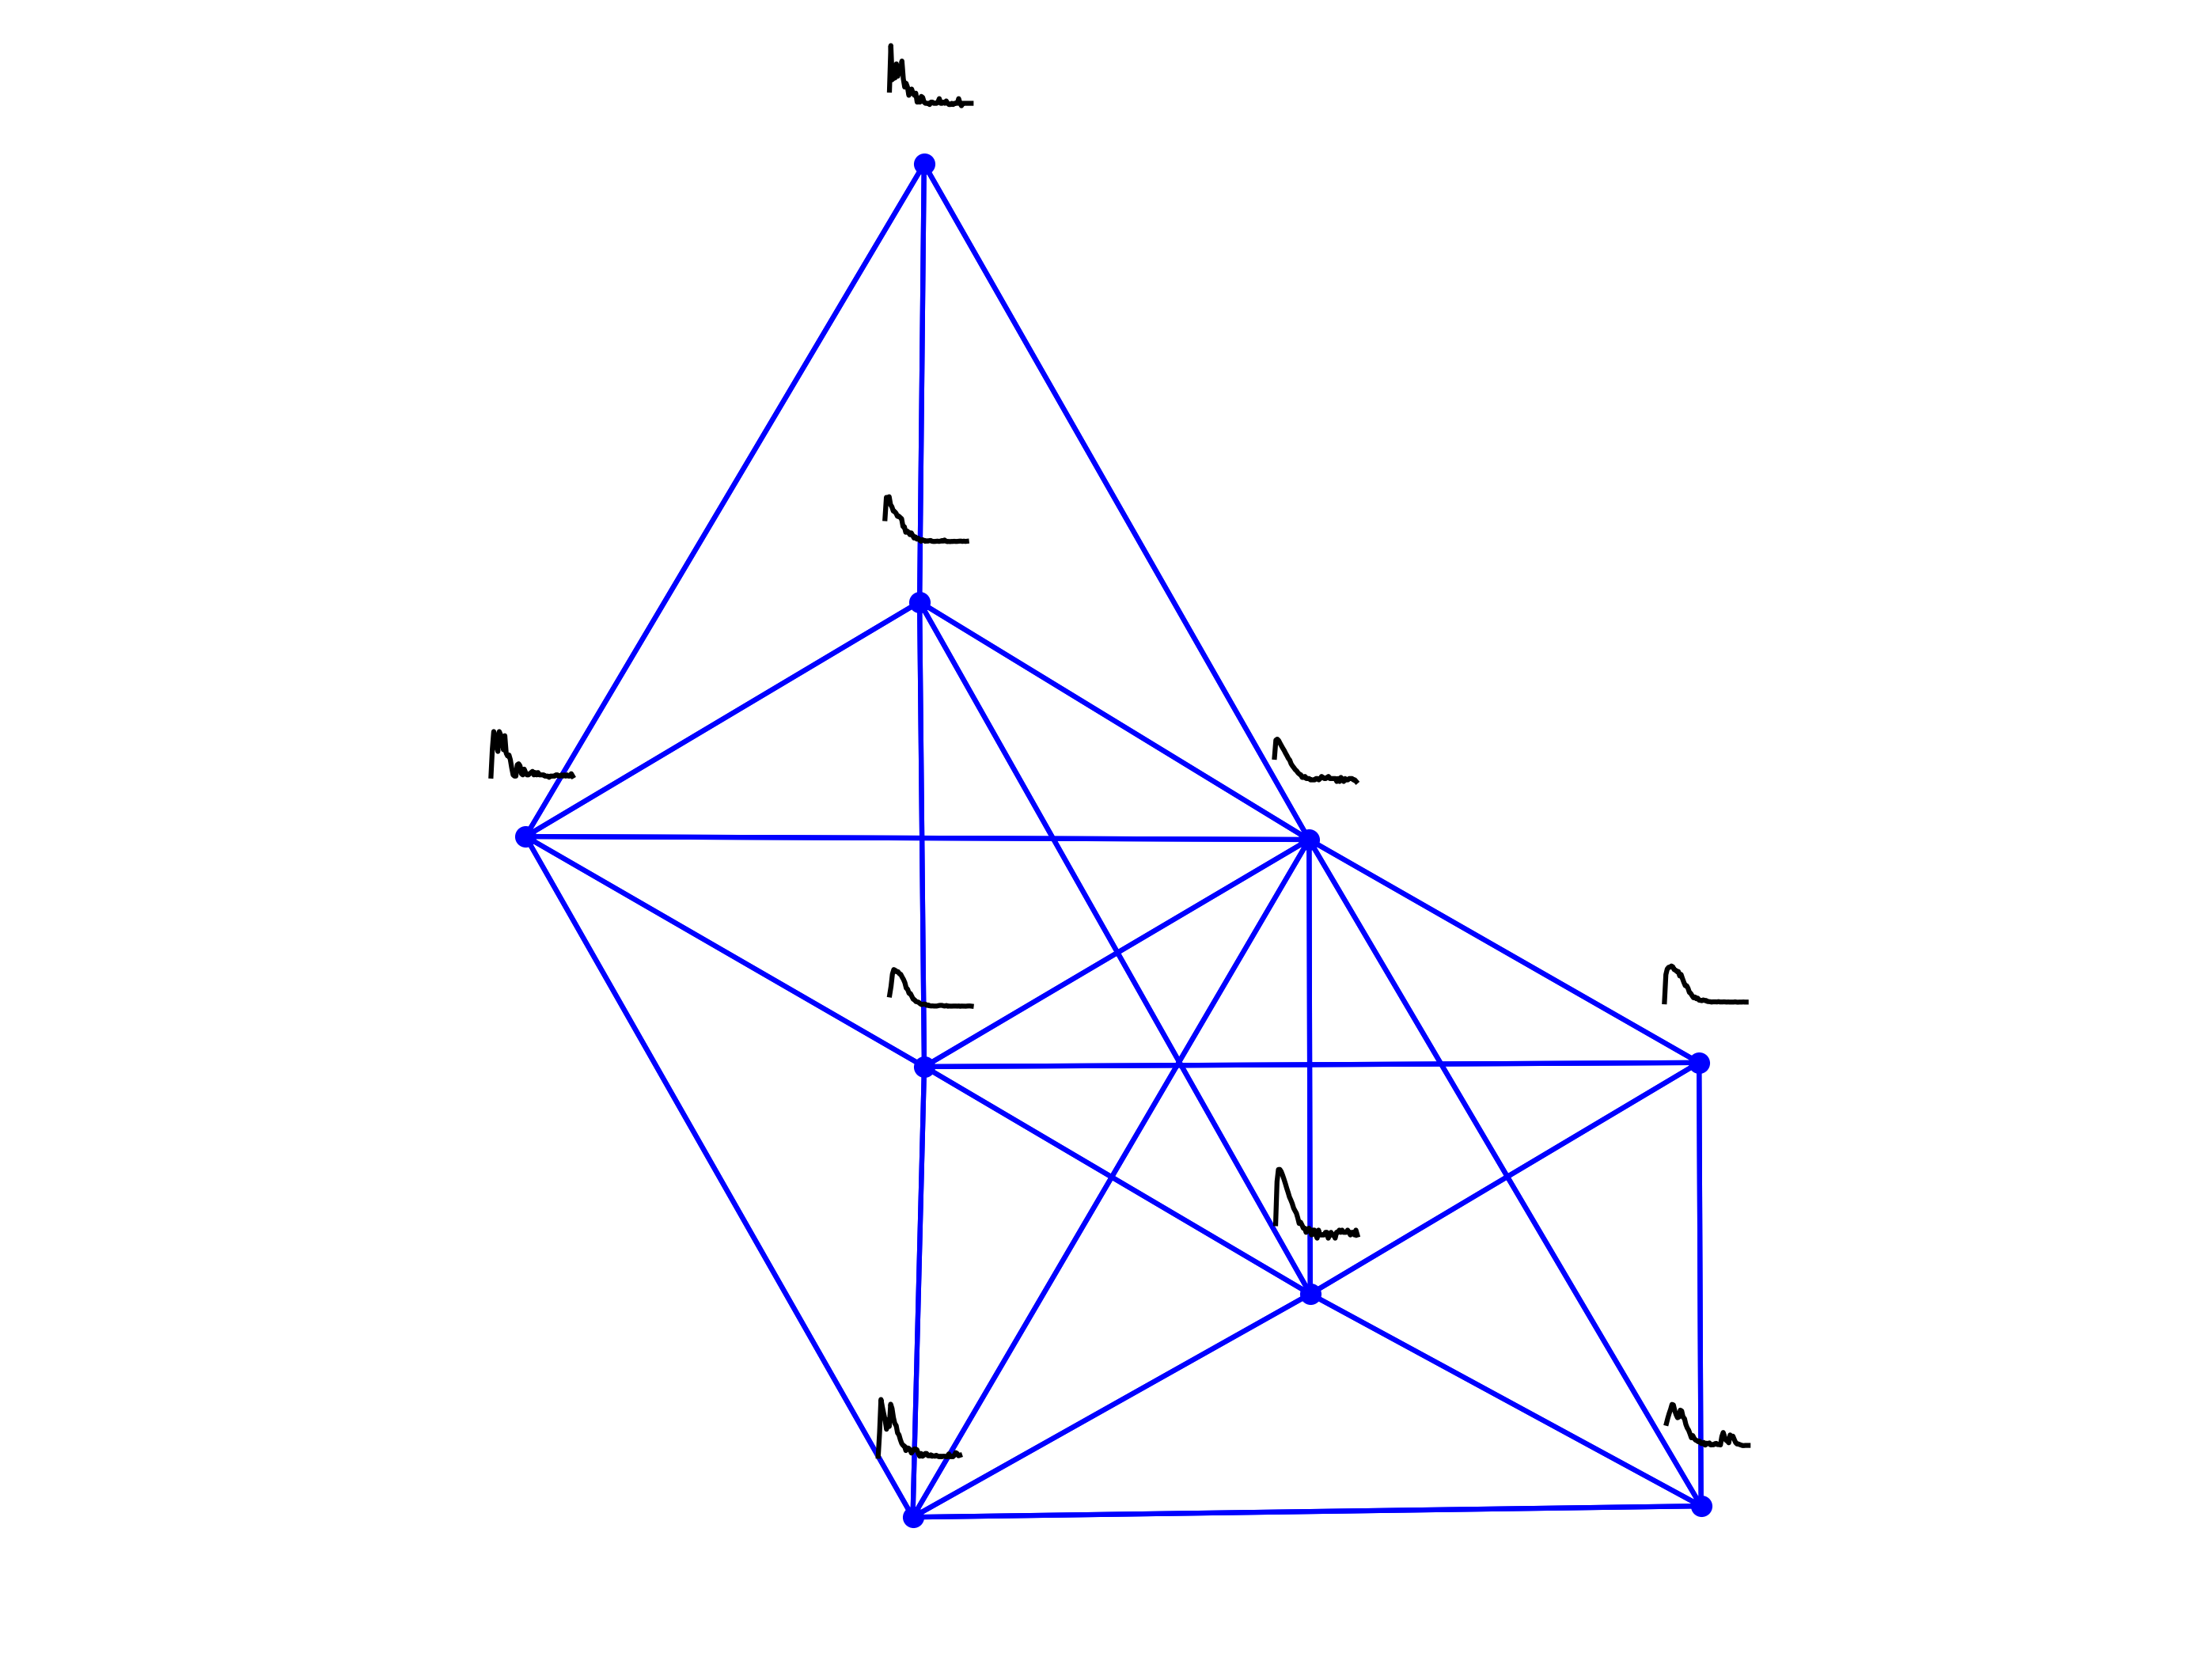

In [181]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()

color="blue"
kw_args_nodes = {"color":color}
kw_args_edges = {"color":color}
kw_args_traces = {}

plot_simple_graph(masked_graph1, ax=ax, kw_args_nodes=kw_args_nodes, kw_args_edges=kw_args_edges, kw_args_traces=kw_args_traces)
ax.axis("off")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [182]:
node_masking_transform =  MaskNode(max_nodes2prune=2)
masked_graph2 = node_masking_transform(masked_graph1)

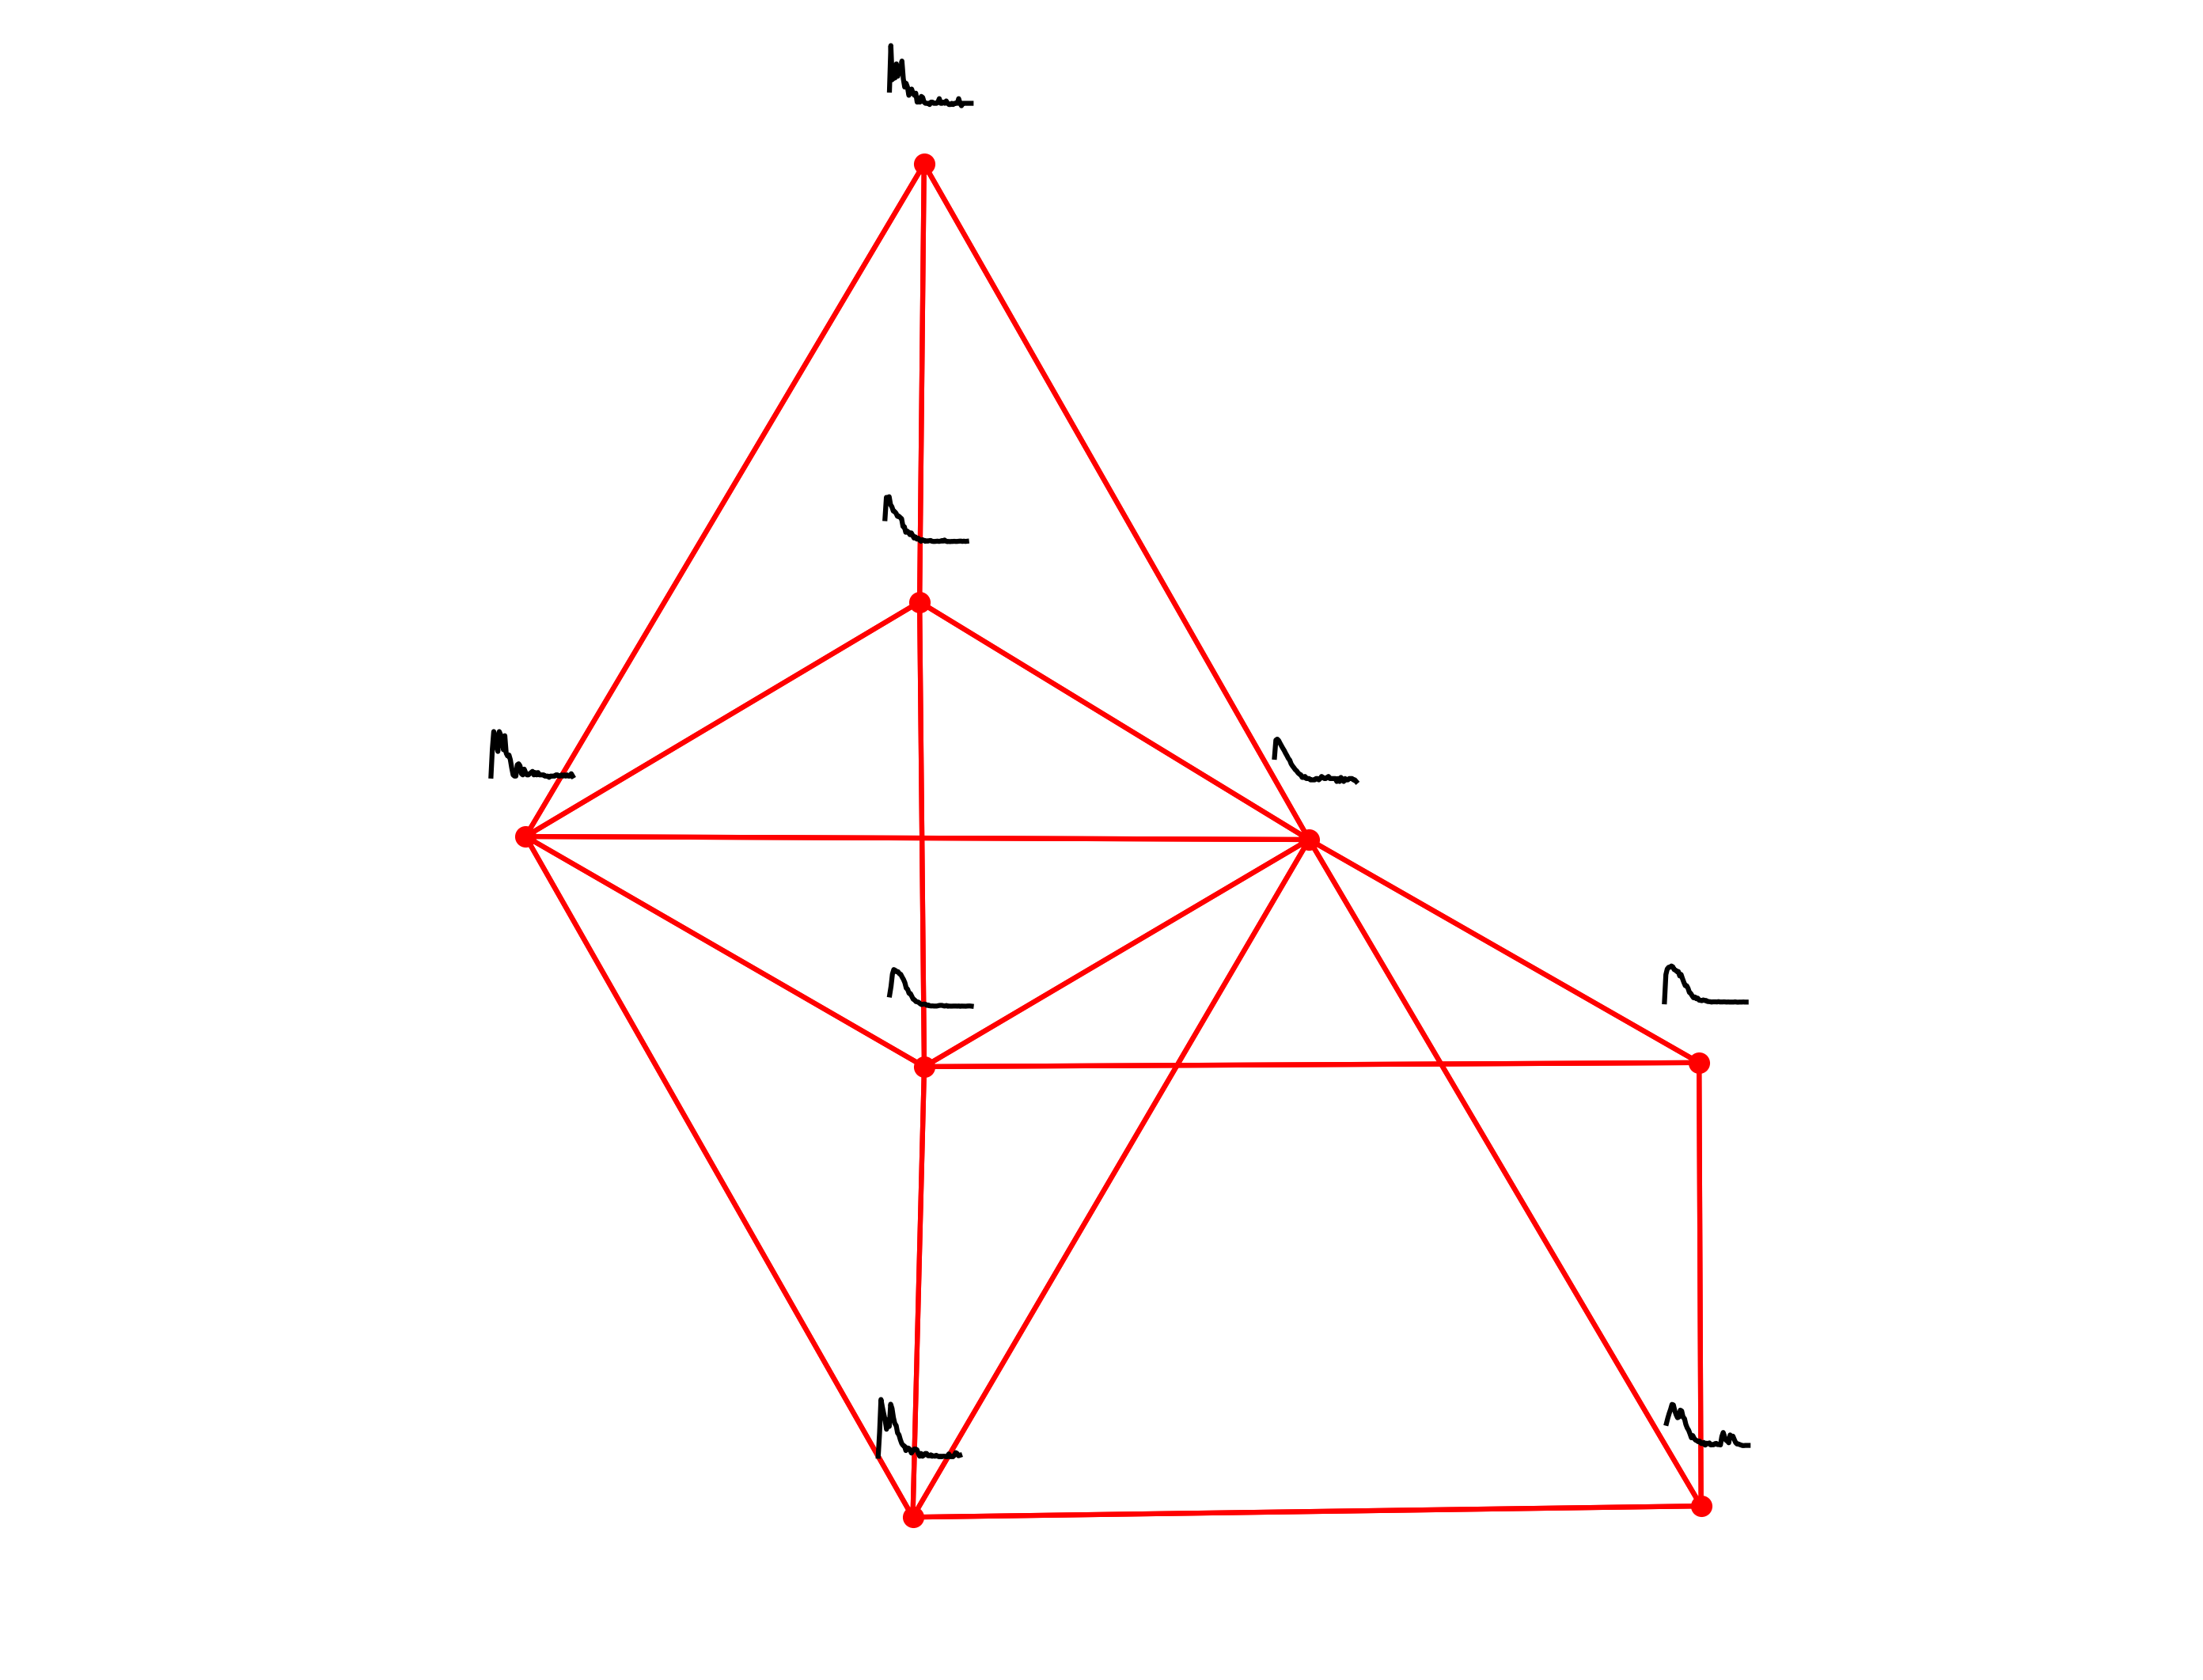

In [185]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()

color="red"
kw_args_nodes = {"color":color}
kw_args_edges = {"color":color}
kw_args_traces = {}

plot_simple_graph(masked_graph2, ax=ax, kw_args_nodes=kw_args_nodes, kw_args_edges=kw_args_edges, kw_args_traces=kw_args_traces)
ax.axis("off")
plt.axis('equal')
plt.tight_layout()
plt.show()

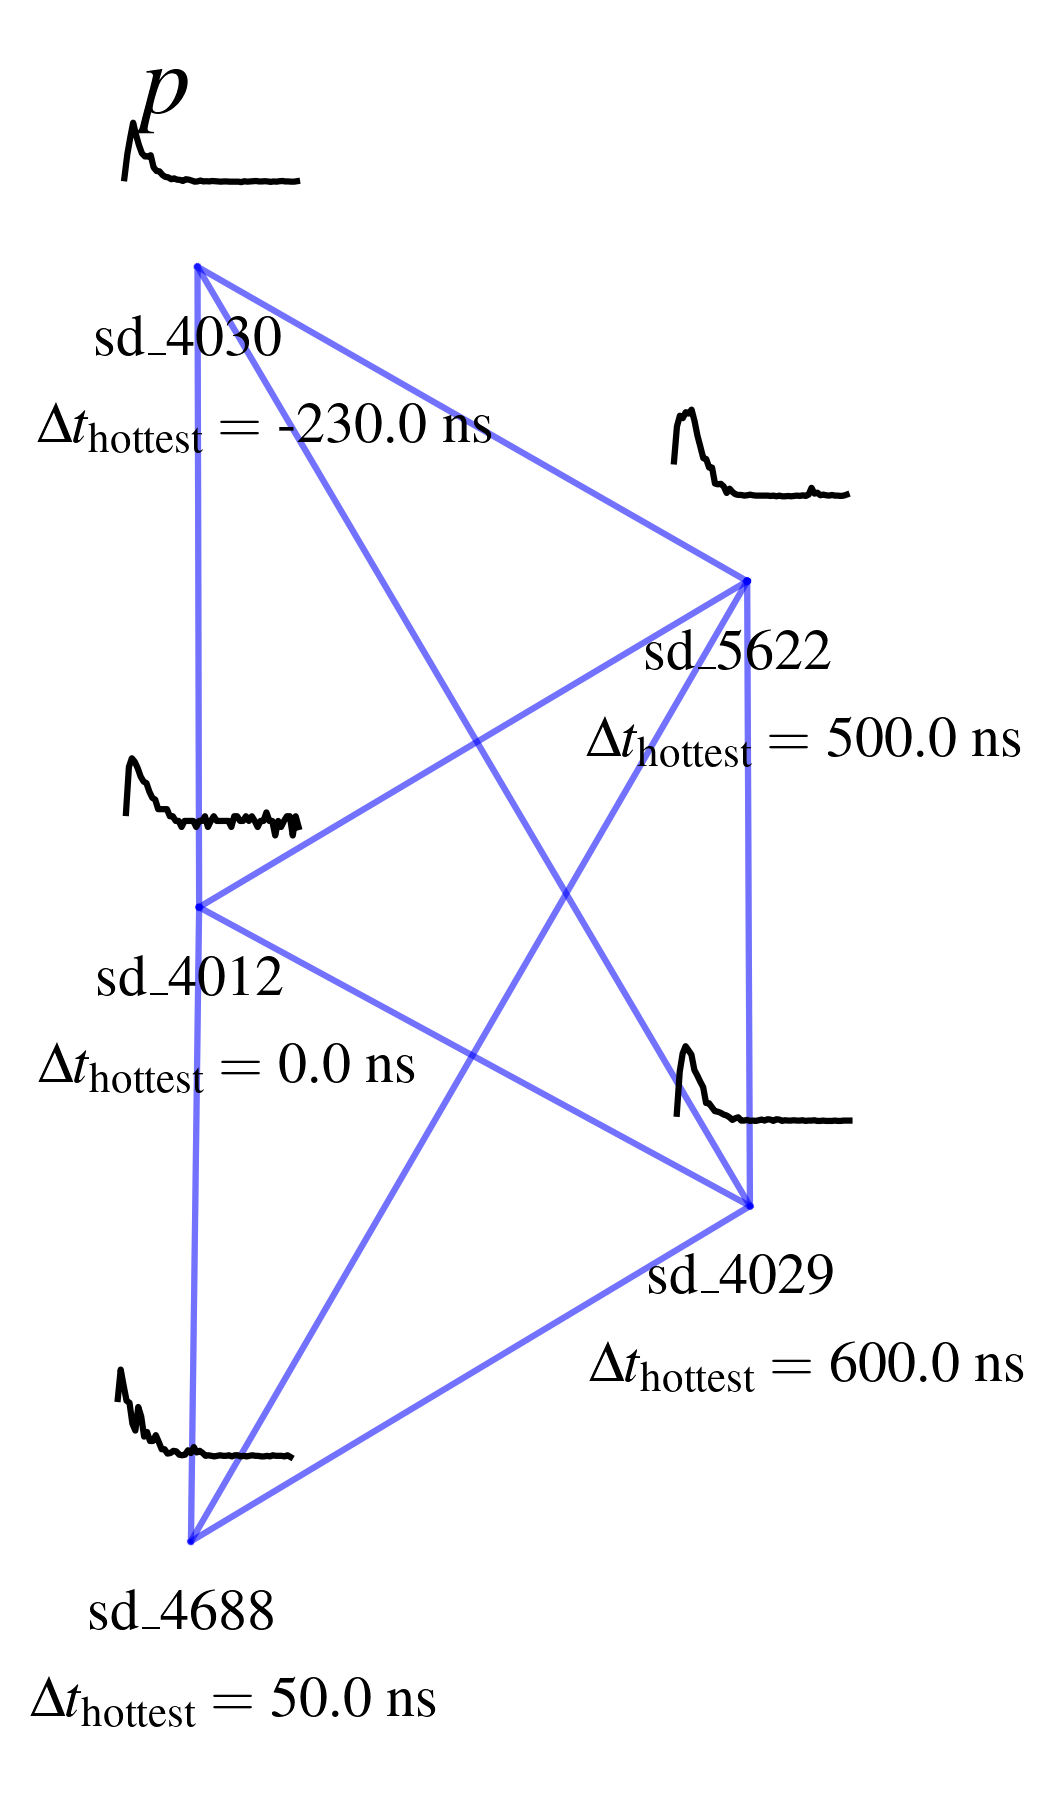

In [63]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()
#plot_graph(
#    graph,
#    "WCD_signal",
#    normalization_dict,
#    ax,
#    node_size_label=r"$S_{WCD}$",
#    size_amplifier=1.5,
#)
plot_graph(
    graph,
    "rho_mu",
    normalization_dict,
    ax,
    plot_edges=True,
    node_color="blue",
    size_amplifier=10,
    node_size_label=r"$\rho_{\mu}$",
    linestyle=None,
    plot_core=False,
    edge_color="blue",
)
ax.set_aspect("equal", adjustable="box")
ax.axis("off")
ax.text(x=0.01, y=0.99, s=r"$\gamma$" if graph.y == 1 else r"$p$",  ha='left', va='top', transform=ax.transAxes)
#ax.legend(loc="upper right", fontsize=14)
# plt.tight_layout()
plt.show()

In [17]:
node_masking_transform =  MaskNode(max_nodes2prune=2)
masked_node = node_masking_transform(graph)

IndexError: tensors used as indices must be long, byte or bool tensors

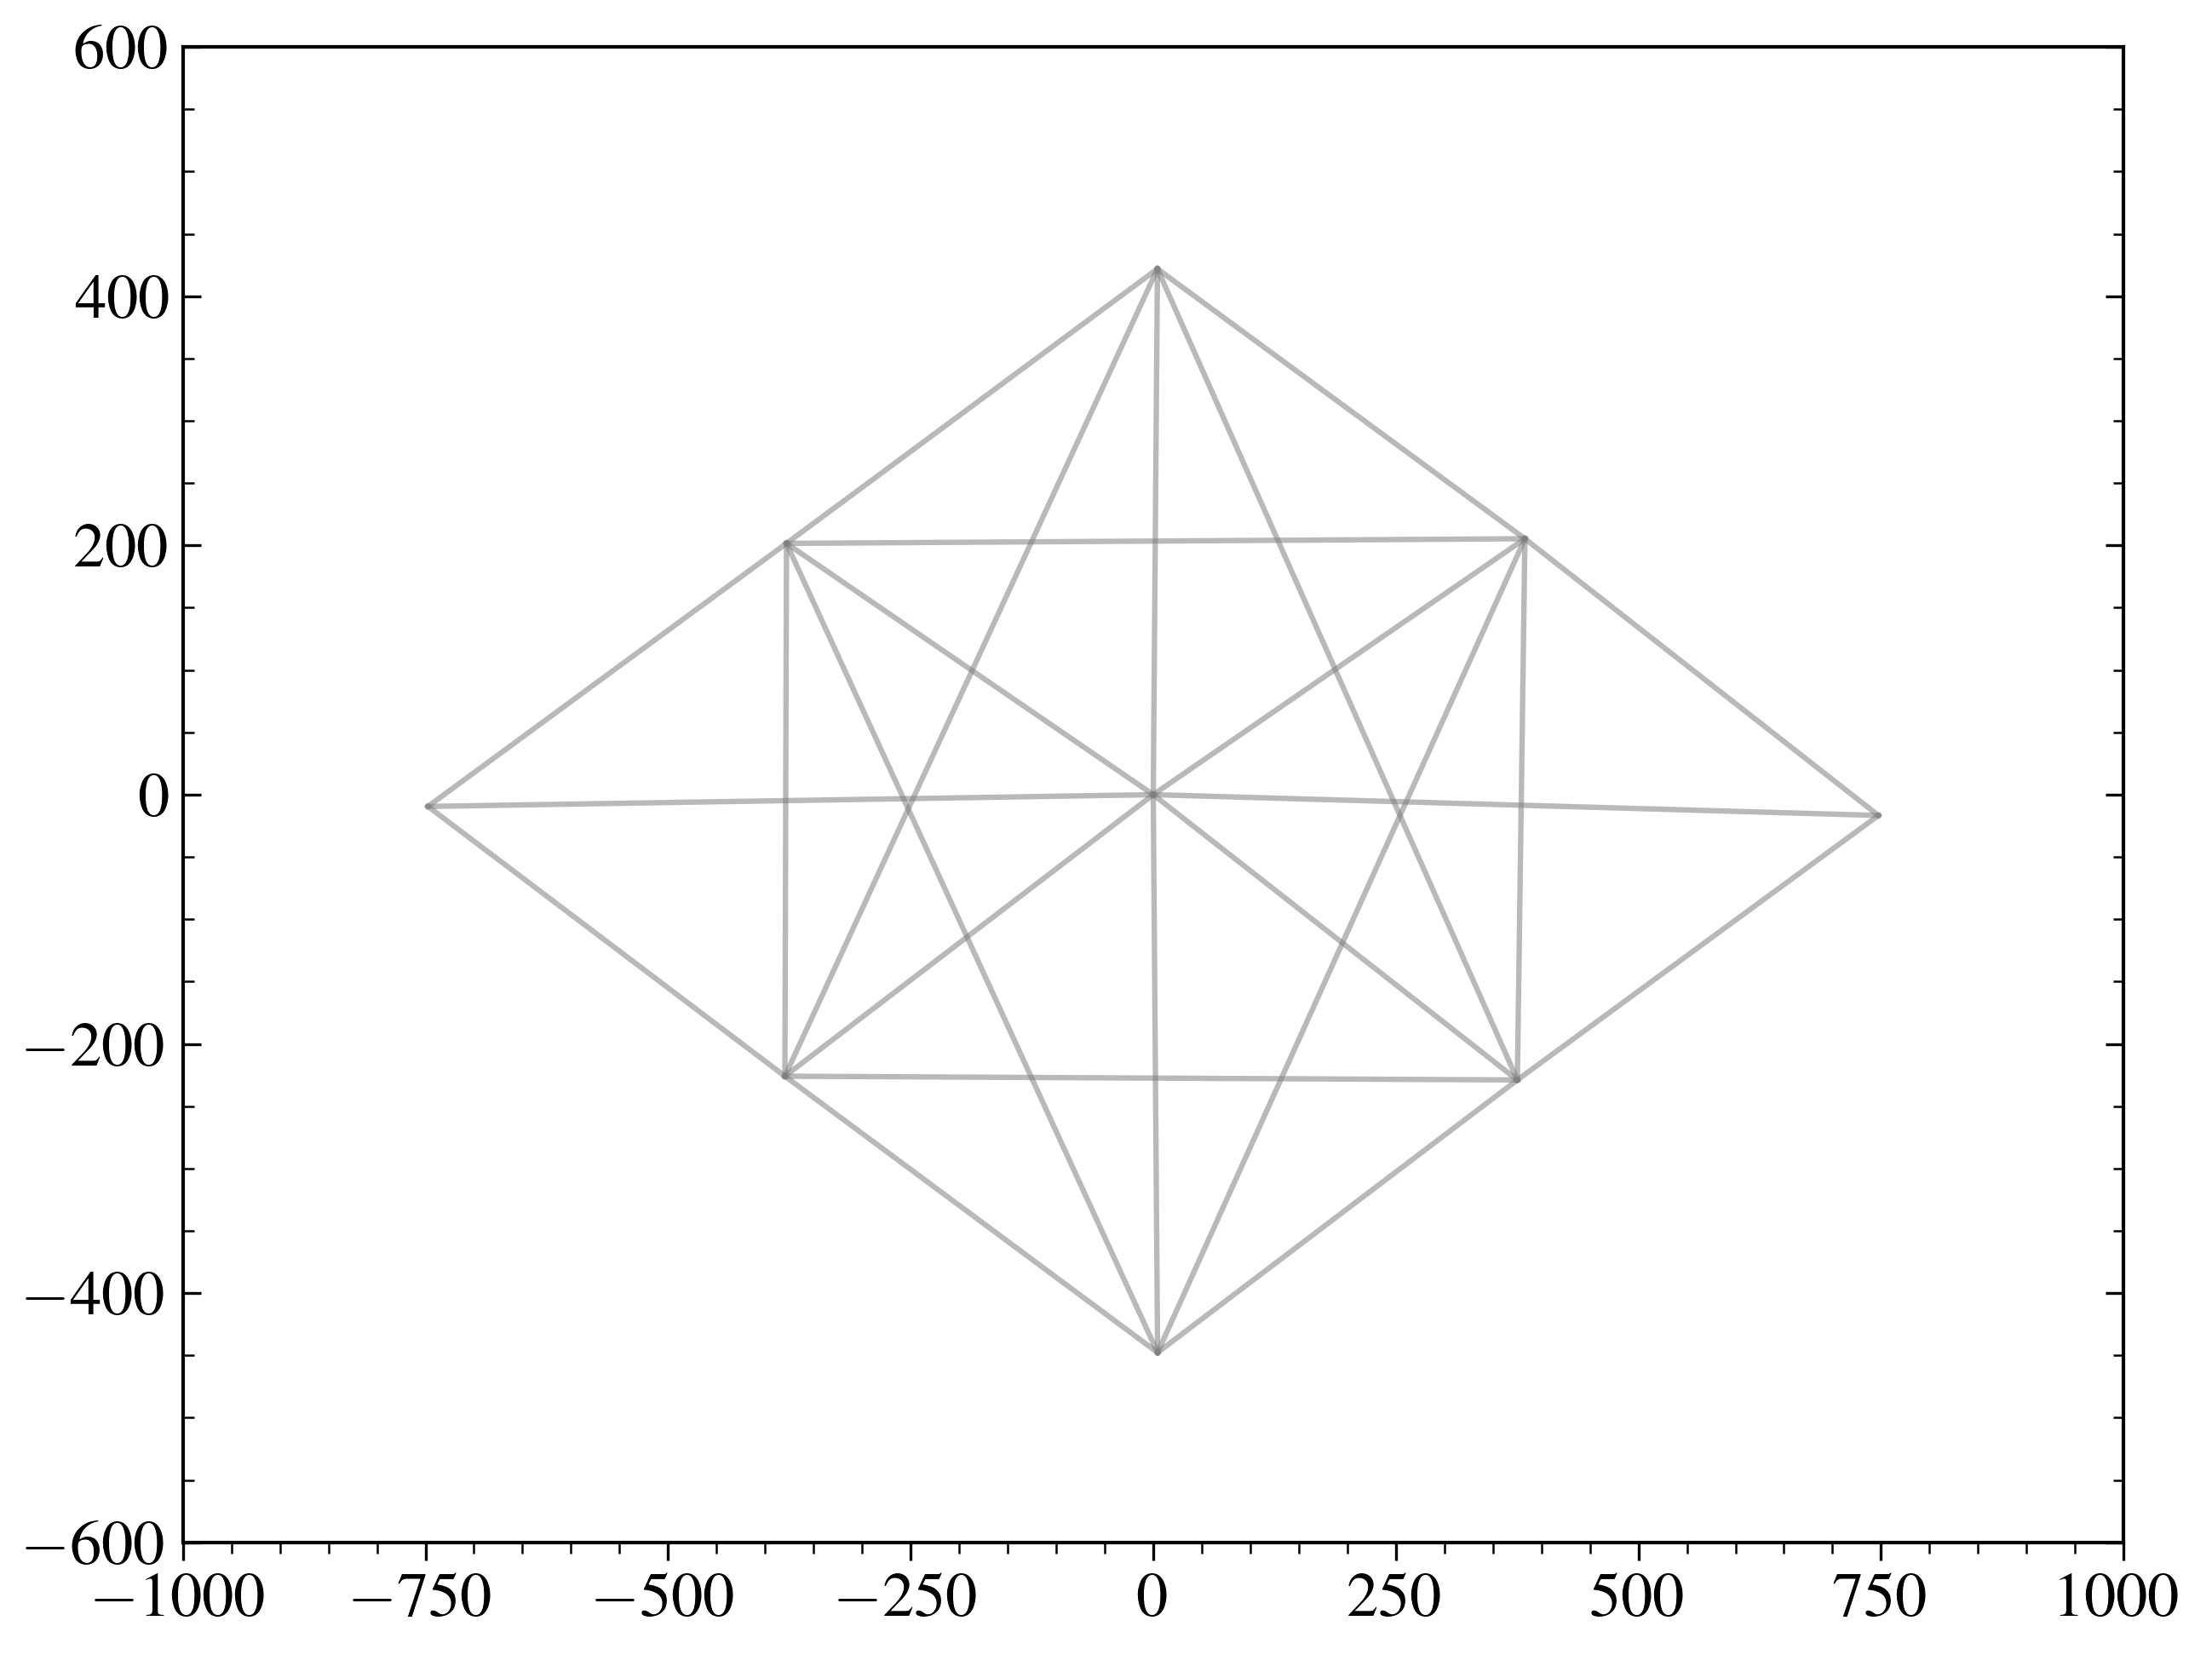

In [18]:
myStyle = MyStyle("1fig", markers=None)
fig, ax = plt.subplots()
plot_graph(
    masked_node,
    "WCD_signal",
    normalization_dict,
    ax,
    node_size_label=r"$S_{WCD}$",
    size_amplifier=1,
)
plot_graph(
    masked_node,
    "rho_mu",
    normalization_dict,
    ax,
    plot_edges=False,
    node_color="red",
    size_amplifier=1.5,
    node_size_label=r"$\rho_{\mu}$",
    linestyle=None,
    plot_core=True,
)
ax.set_aspect("equal", adjustable="box")
ax.axis("off")
ax.text(x=0.01, y=0.99, s=r"$\gamma$" if graph.y == 1 else r"$p$",  ha='left', va='top', transform=ax.transAxes)
ax.legend(loc="upper right", fontsize=14)
# plt.tight_layout()
plt.show()

In [16]:
# myStyle = MyStyle("1fig", markers=None)
# fig, ax = plt.subplots()
# station_features = [
#     "$x$",
#     "$y$",
#     "$z$",
#     r"$\Delta t_{{\text{{hottest}}}}$",
#     r"$N_{\text{PMT}}$",
#     r"$S_{\text{WCD}}$",
#     r"$A_{\mu}$",
#     r"$\rho_{\mu}$",
# ]
# # Create the table with adjusted position, size, and font size
# table_x = ax.table(
#     cellText=graph.x.numpy(),
#     colWidths=[0.3] * len(graph.station_features),
#     rowLabels=graph.station_list,
#     colLabels=station_features,
#     loc="center",
#     bbox=[0, 0, 1, 1],
#     cellLoc="center",
#     fontsize=24,
# )  # Adjust fontsize as needed
# ax.axis("off")

# plt.show()

In [17]:
# myStyle = MyStyle("1fig", markers=None)
# fig, ax = plt.subplots()

# adj_matrix = (
#     torch_geometric.utils.to_torch_coo_tensor(graph.edge_index).to_dense().numpy()
# )
# # Create the table
# table_edges = ax.table(
#     cellText=adj_matrix,
#     colWidths=[0.1] * len(graph.station_list),
#     rowLabels=graph.station_list,
#     colLabels=graph.station_list,
#     loc="center",
#     bbox=[0, 0, 1, 1],
#     cellLoc="center",
#     fontsize=18,
# )

# # Iterate over table cells and shade non-zero cells with light grey
# for i in range(len(adj_matrix)):
#     for j in range(len(adj_matrix[i])):
#         if adj_matrix[i][j] != 0:
#             table_edges[(i + 1, j)].set_facecolor("grey")  # Light grey color

# # Turn off axis and adjust layout
# ax.axis("off")
# plt.tight_layout()
# plt.show()

In [18]:
# myStyle = MyStyle("1fig", markers=None)
# fig, ax = plt.subplots()
# trimmed_traces = graph.x_traces[:, :25].numpy()
# table_edges = ax.table(
#     cellText=trimmed_traces,
#     colWidths=[0.1] * trimmed_traces.shape[1],
#     rowLabels=graph.station_list,
#     loc="center",
#     bbox=[0, 0, 1, 1],
#     cellLoc="center",
#     fontsize=18,
# )  # Adjust fontsize as needed
# ax.axis("off")
# plt.tight_layout()
# plt.show()

In [19]:
dir_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/"
root_path = "/sps/pauger/users/erodriguez/PhotonDiscrimination/root/"

# set paths according to index
train_paths = list(train_index.iloc[:, 0].values)
train_paths = list(map(lambda item: dir_path + item + ".json", train_paths))
val_paths = list(validation_index.iloc[:, 0].values)
val_paths = list(map(lambda item: dir_path + item + ".json", val_paths))
test_paths = list(test_index.iloc[:, 0].values)
test_paths = list(map(lambda item: dir_path + item + ".json", test_paths))

# generate Datasets
train_PyG_ds = SD433UMDatasetPyG(
    file_paths=train_paths,
    norm_dict=normalization_dict,
    root=root_path,
    sample_PMTs=True,
    sample_MD_mods=True,
)
val_PyG_ds = SD433UMDatasetPyG(
    file_paths=val_paths,
    norm_dict=normalization_dict,
    root=root_path,
    sample_PMTs=True,
    sample_MD_mods=True,
)
test_PyG_ds = SD433UMDatasetPyG(
    file_paths=test_paths,
    norm_dict=normalization_dict,
    root=root_path,
    sample_PMTs=True,
    sample_MD_mods=True,
)

Processing...
100%|██████████| 146398/146398 [00:21<00:00, 6863.67it/s] 


Error processing file /sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/Photon_17.0_17.5_080595_20.json: 'pmt_3'
Error processing file /sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/Photon_17.0_17.5_011102_11.json: 'pmt_2'


Done!
Processing...
100%|██████████| 25098/25098 [00:03<00:00, 6874.54it/s] 
Done!
Processing...
100%|██████████| 37645/37645 [00:04<00:00, 8109.63it/s] 


Error processing file /sps/pauger/users/erodriguez/PhotonDiscrimination/JSONfiles/Photon_17.0_17.5_080595_20.json: 'pmt_3'


Done!


In [20]:
# generate Loaders
train_loader = DataLoader(train_PyG_ds, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_PyG_ds, batch_size=32, num_workers=8)
test_loader = DataLoader(test_PyG_ds, batch_size=32, num_workers=8)

In [21]:
for batch_idx, data in enumerate(
    tqdm(train_loader, desc="Batch", position=0, leave=True)
):
    if torch.isnan(data.x).any():
        print("Batch id: ",batch_idx)
        print("Nan on Features")
        print(data.x)
        saved_problem = data.x
        nan_indices = torch.nonzero(torch.isnan(saved_problem)).flatten()
        print("Indices of NaNs:", nan_indices.tolist())
    if torch.isnan(data.x_traces).any():
        print("Batch id: ",batch_idx)
        print("Nan on Traces")
        saved_problem = data.x_traces
        nan_indices = torch.nonzero(torch.isnan(saved_problem)).flatten()
        print("Indices of NaNs:", nan_indices.tolist())
        print("Features")
        print(data.x[nan_indices[0], :])
        print("Norm. Traces after Sampling")
        print(data.x_traces[nan_indices[0],:])

Batch:  28%|██▊       | 1288/4575 [37:48<1:36:28,  1.76s/it]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch_geometric/data/dataset.py", line 263, in __getitem__
    data = self.get(self.indices()[idx])
  File "/pbs/home/e/erodrigu/TesisPhDEzequielRodriguez/Code/my_utils/gnn_dataset_utilities.py", line 719, in get
    data = torch.load(os.path.join(self.processed_dir, f"{self.id_list[idx]}.pt"))
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch/serialization.py", line 699, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch/serialization.py", line 231, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/sps/pauger/users/erodriguez/envs/pyg/lib/python3.8/site-packages/torch/serialization.py", line 212, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: '/sps/pauger/users/erodriguez/PhotonDiscrimination/root/processed/Photon_16.5_17.0_030179_07.pt'


In [ ]:
for batch_idx, data in enumerate(
    tqdm(val_loader, desc="Batch", position=0, leave=True)
):
    if torch.isnan(data.x).any():
        print("Batch id: ",batch_idx)
        print("Nan on Features")
        print(data.x)
        saved_problem = data.x
        nan_indices = torch.nonzero(torch.isnan(saved_problem)).flatten()
        print("Indices of NaNs:", nan_indices.tolist())
    if torch.isnan(data.x_traces).any():
        print("Batch id: ",batch_idx)
        print("Nan on Traces")
        saved_problem = data.x_traces
        nan_indices = torch.nonzero(torch.isnan(saved_problem)).flatten()
        print("Indices of NaNs:", nan_indices.tolist())
        print("Features")
        print(data.x[nan_indices[0], :])
        print("Norm. Traces after Sampling")
        print(data.x_traces[nan_indices[0],:])

In [ ]:
for batch_idx, data in enumerate(
    tqdm(test_loader, desc="Batch", position=0, leave=True)
):
    if torch.isnan(data.x).any():
        print("Batch id: ",batch_idx)
        print("Nan on Features")
        print(data.x)
        saved_problem = data.x
        nan_indices = torch.nonzero(torch.isnan(saved_problem)).flatten()
        print("Indices of NaNs:", nan_indices.tolist())
    if torch.isnan(data.x_traces).any():
        print("Batch id: ",batch_idx)
        print("Nan on Traces")
        saved_problem = data.x_traces
        nan_indices = torch.nonzero(torch.isnan(saved_problem)).flatten()
        print("Indices of NaNs:", nan_indices.tolist())
        print("Features")
        print(data.x[nan_indices[0], :])
        print("Norm. Traces after Sampling")
        print(data.x_traces[nan_indices[0],:])